In [1]:
import cv2
import numpy as np
from datascience import *
import matplotlib as mpl
from matplotlib import pyplot as plt
import sys
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 120
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [2]:
images = []
labeled_imgs = []
original_img = []
original_img1 = []
filter_img = []
image_names = []

In [46]:
#access img directory
dirname = 'Anolis_cristatellus_images/'

#create an iterator object for img directory
directory = os.scandir(dirname)

#print(os.listdir(dirname))
def threshold(customized):
    index = 0;
    images.clear
    
    if(len(customized) == 0):
        print("THRESHOLDING WITH OTSU INITIALLY")
    #iterates through each image in the directory
    for img in directory:
        img_name = img.name
        if (img_name != '.ipynb_checkpoints'):
            if(len(customized) == 0):
                image_names.append(img.name)
            
            #read the image, convert to grayscale add to array and title + blur
            img = cv2.imread(dirname + "" + img_name)
            original_img1.append(img)
            
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            original_img.append(gray)
            title = img_name
            img = gray
            blur = cv2.GaussianBlur(img,(5,5),1)

            blur = cv2.bilateralFilter(blur,10,10,100)
            filter_img.append(blur)
            
            #if the customized block size has not yet been determined this if statement will run
            if(len(customized)==0):
                #print("Initial Value used")
                ret, thresh = cv2.threshold(blur,0 , 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
                
            #if customized block size has been determined
            else:
                thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size[index][0], -2)
                
            kernel = np.ones((3,3),np.uint8)
            
            #if the customized iteration number has not yet been determined this if statement will run
            if(len(customized)==0):
                opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 4)
            
            #if customized array is greater than size 0 iteration number has been determined
            else:
                opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations=block_size[index][1])

            
            # sure background area
            sure_bg = cv2.dilate(opening,kernel,iterations=1)

            # Finding sure foreground area: What does cv2.DIST do?
            dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
            ret, sure_fg = cv2.threshold(dist_transform, 1.5, 255, 0) 

            # Finding unknown region
            sure_fg = np.uint8(sure_fg)
            unknown = cv2.subtract(sure_bg,sure_fg)
            
            #adding sure_fg binarization to list of images
            images.append(sure_fg)

#             plt.subplot(1,3,1), plt.imshow(gray, 'gray')
#             plt.subplot(1,3,2), plt.imshow(sure_fg, 'gray') 
        
            # Label and count (taken from maggie's code)
            # source: https://medium.com/analytics-vidhya/images-processing-segmentation-and-objects-counting-in-an-image-with-python-and-opencv-216cd38aca8e
            count, labels = cv2.connectedComponents(sure_fg)                
            count = count - 1 # background doesn't count as a scale
            label_hue = np.uint8(179 * labels / np.max(labels))
            blank_ch = 255 * np.ones_like(label_hue)
            labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
            labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
            labeled_img[label_hue == 0] = 0
            
            if(len(customized) != 0):
                labeled_imgs.append(labeled_img)
            index += 1
            
print("INITIAL TEST BINARIZATION\n")
threshold([])

INITIAL TEST BINARIZATION

THRESHOLDING WITH OTSU INITIALLY


In [47]:
num_scales_and_average_size = []
sizes_of_scales = []
total_stats = []

print(len(images))
#iterates through images to determine average size and count of scales in␣initial binarization
for i in np.arange(len(images)):    
    img = images[i]

    binary_map = (img > 0).astype(np.uint8)
    connectivity = 4 # or whatever you prefer
    output = cv2.connectedComponentsWithStats(binary_map, connectivity, cv2.CV_32S)
    num_labels = output[0]
    
    # The second cell is the label matrix
    labels = output[1]
    # The third cell is the stat matrix
    stats = output[2]
    # The fourth cell is the centroid matrix
    centroids = output[3]
    
    sizes_of_scales.append((stats[1:,-1]))
    num_scales_and_average_size.append(([num_labels, np.average(stats[1:,-1])]))
    total_stats.append([num_labels, stats[1:,-1], stats[1:,-1]])

110


In [48]:
block_size = []
for stat in num_scales_and_average_size:
    index = 0
    if stat[0] <= 3:
        block_size.append([15,1])
    elif stat[1] < 350:
        block_size.append([25, 1])
    elif stat[1] < 550:
        block_size.append([45, 3])
    else:
        block_size.append([65, 4])
    index +=1
        
size_and_iter = Table().with_columns("img_name", image_names, "block_size", [i[0]for i in block_size], "iterations" ,[i[1] for i in block_size])
size_and_iter.show()

In [49]:
dirname = 'Anolis_cristatellus_images/'
#create an iterator object for img directory
directory = os.scandir(dirname)
images = []

threshold(block_size)


In [50]:
all_scale_counts = [i[0] for i in total_stats]
all_sizes = [i[1] for i in total_stats]
#sorts all_sizes so that the sizes of the scales are arranged from largest to␣smallest in array
for array_index in np.arange(len(all_sizes) - 1):
    all_sizes[array_index].sort()
    all_sizes[array_index] = all_sizes[array_index][::-1]
    averages = []
for size_array in all_sizes:
    num_nums = (np.rint(len(size_array)/2)).astype(int)
    averages = np.append(averages, np.average(size_array[0:num_nums]))

In [51]:
def overlay(bw_img, color_mask, w1=0.2, w2=0.95):
    a = cv2.cvtColor(bw_img, cv2.COLOR_GRAY2RGB)
    a -= np.min(a)
    a = a/np.max(a)*255
    a = np.clip(a, a_min=0, a_max=255).astype(int)
    b = np.clip(color_mask, a_min=0, a_max=255).astype(int)
    c = cv2.addWeighted(b,w1,a,w2,0)
    return c

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TRYING TO CLEAN UP THE IMAGES AND REMOVE SMALL SPECKELS: SHOULD TAKE INTO ACCOUNT DISTANCE AND SIZE
Images 55
[25, 1]
2
Countors detected: 12


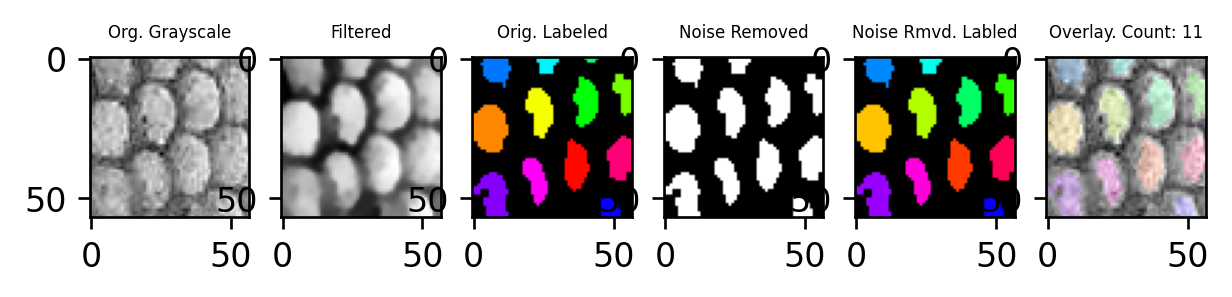

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 24


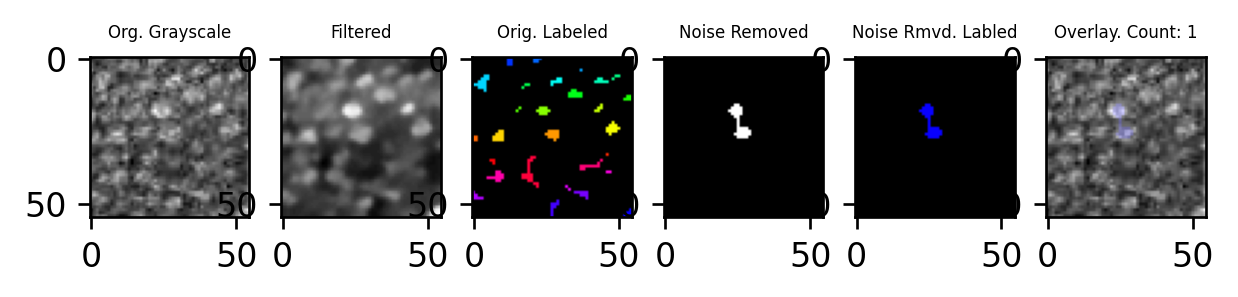

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[65, 4]
2
Countors detected: 8


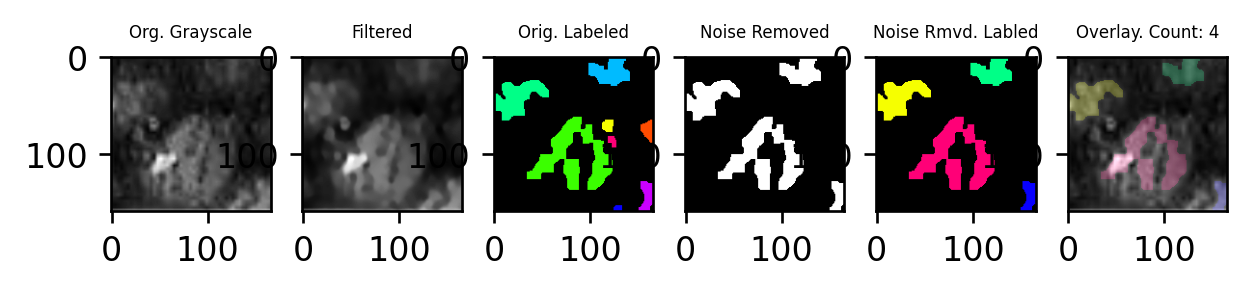

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[65, 4]
2
Countors detected: 12


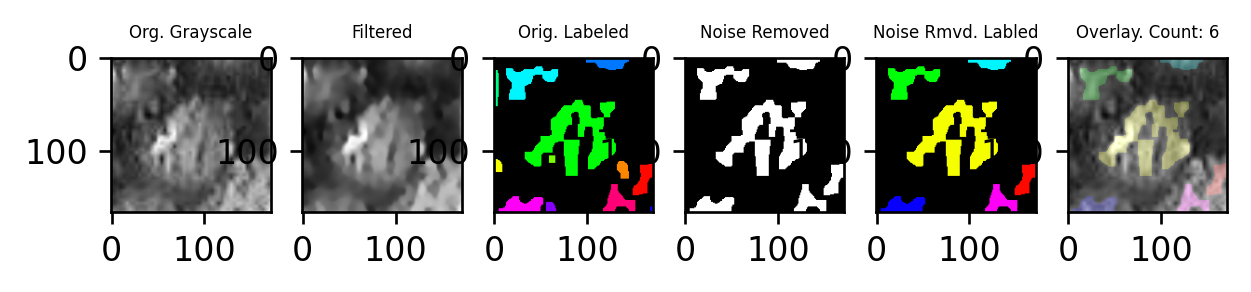

[25, 1]
2
Countors detected: 45


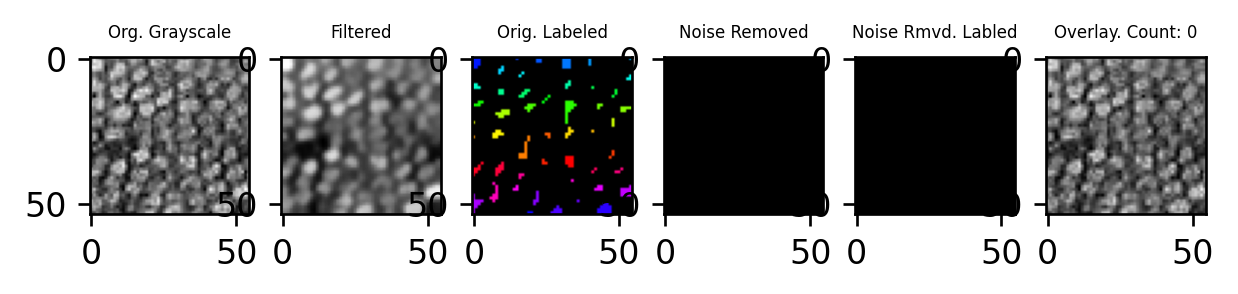

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 40


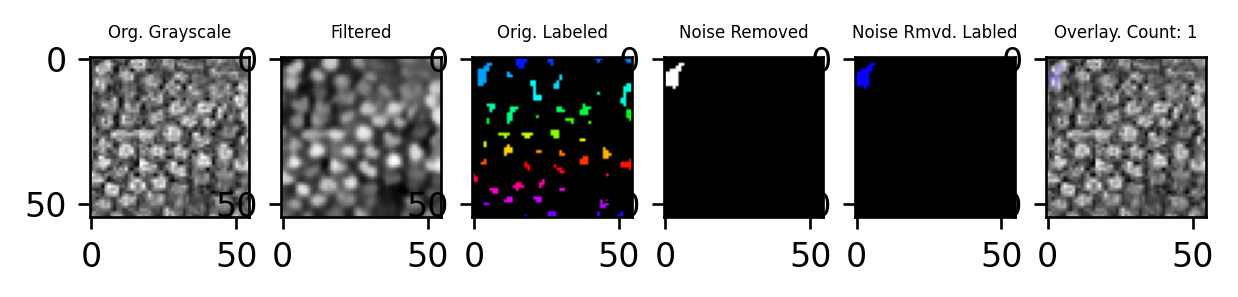

[25, 1]
2
Countors detected: 31


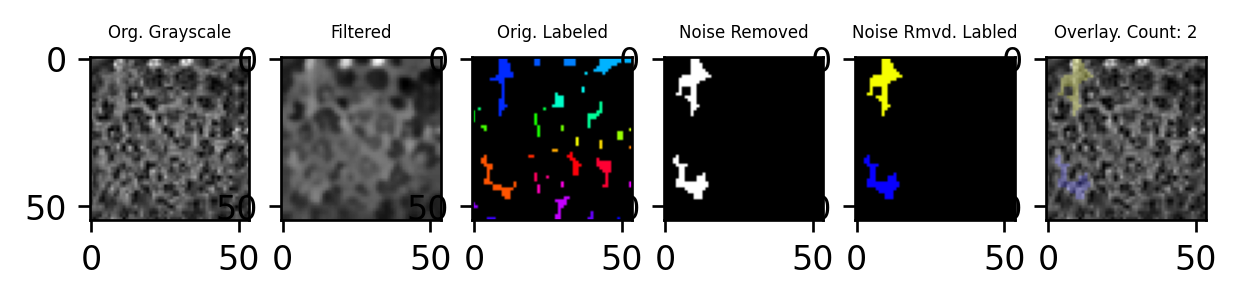

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[65, 4]
2
Countors detected: 12


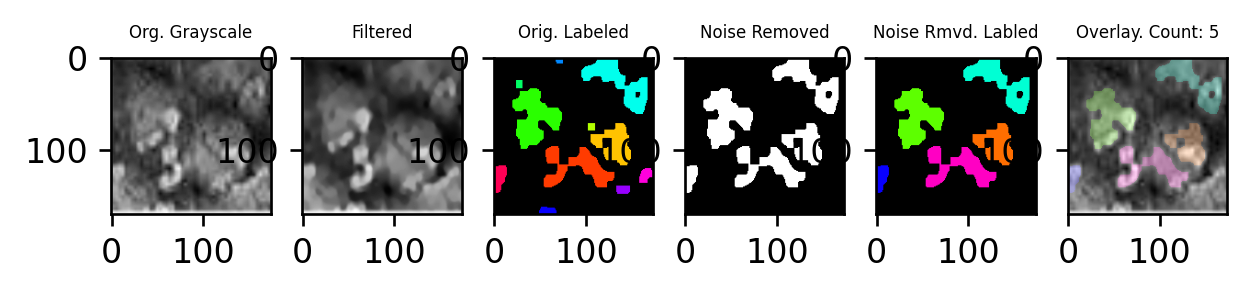

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[65, 4]
2
Countors detected: 13


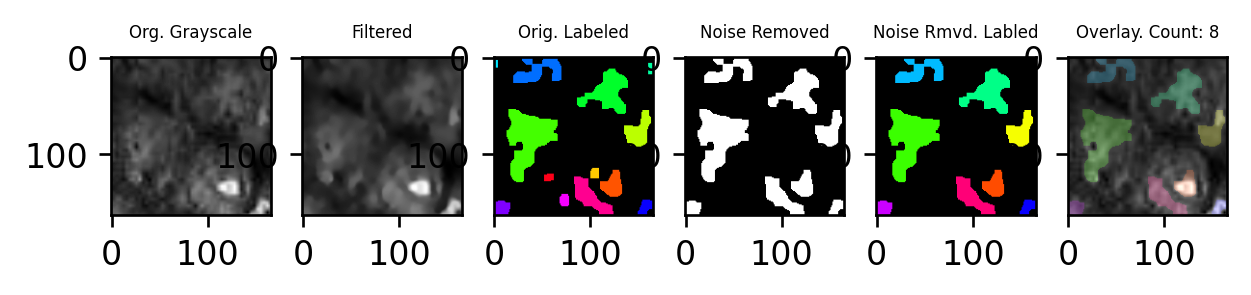

[25, 1]
2
Countors detected: 23


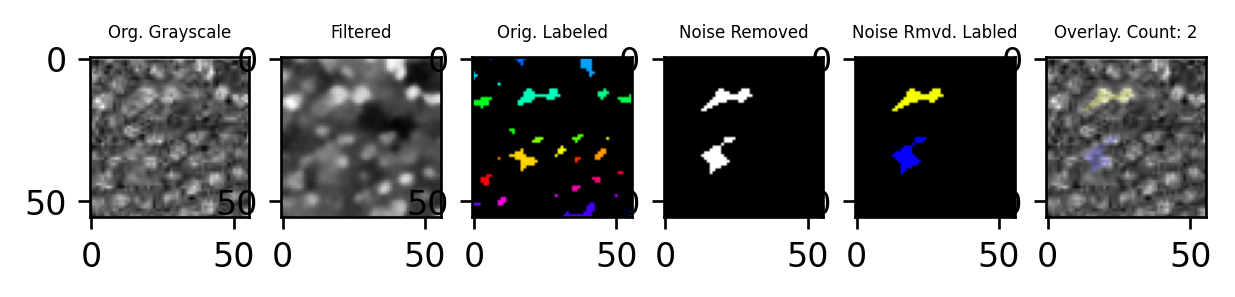

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 14


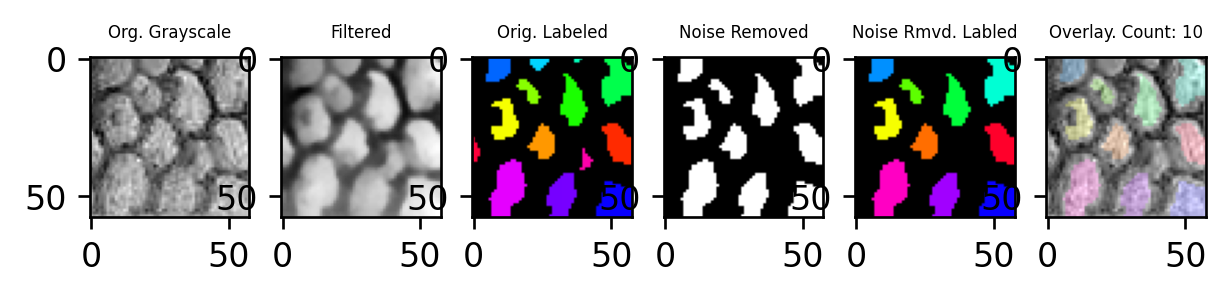

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 23


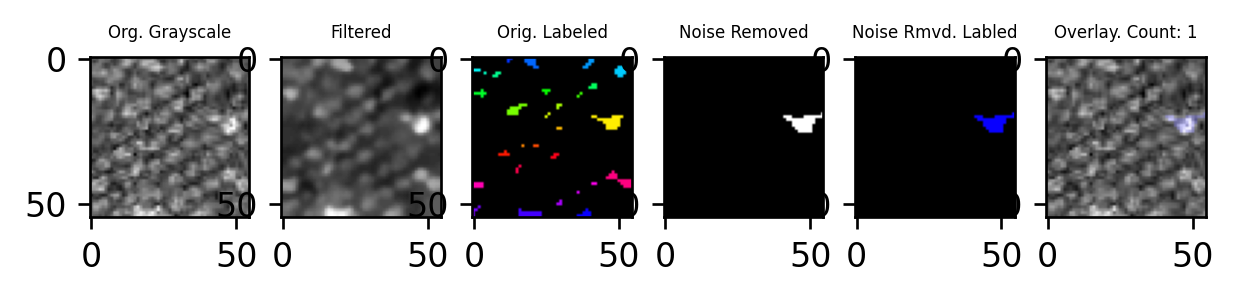

[65, 4]
2
Countors detected: 12


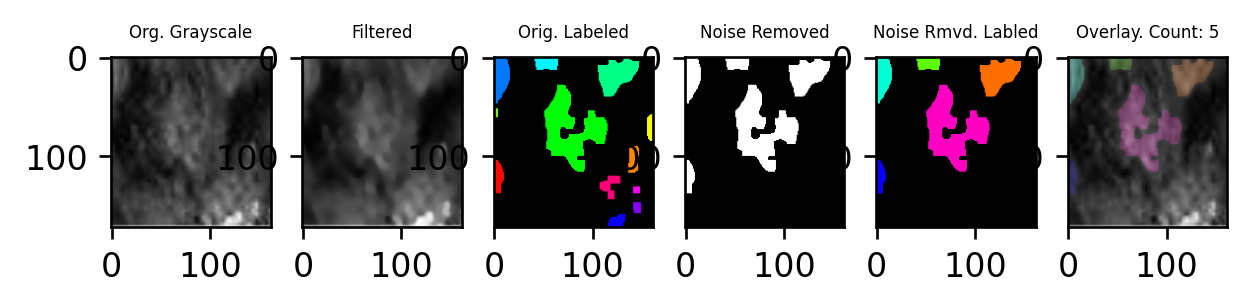

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 29


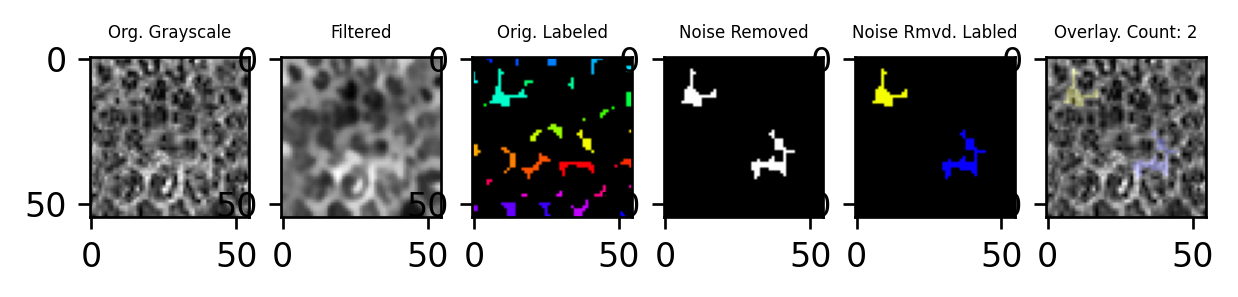

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 44


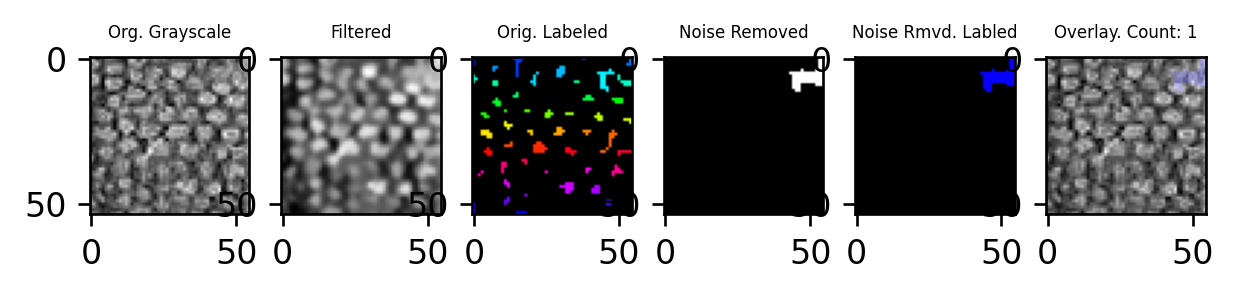

[25, 1]
2
Countors detected: 34


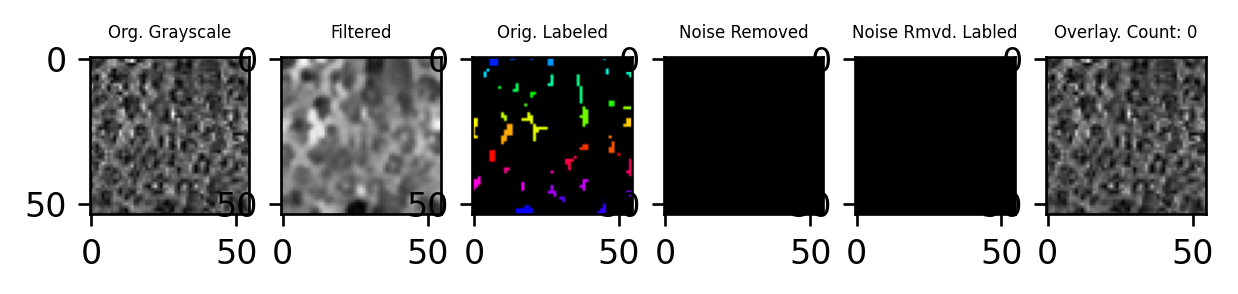

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[65, 4]
2
Countors detected: 12


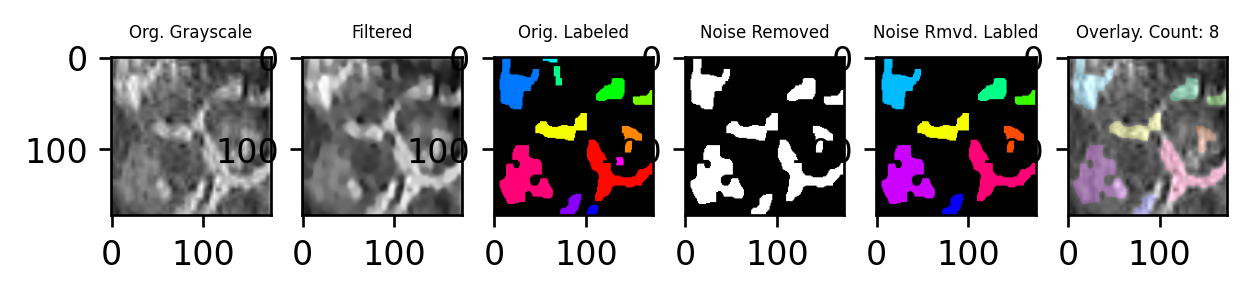

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 13


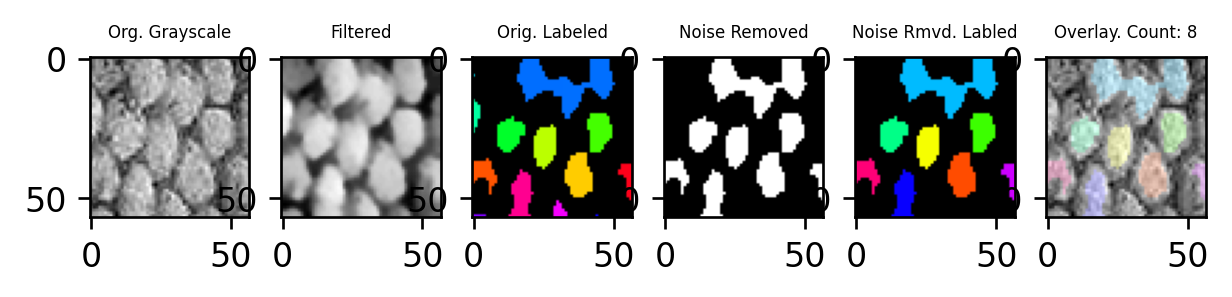

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 48


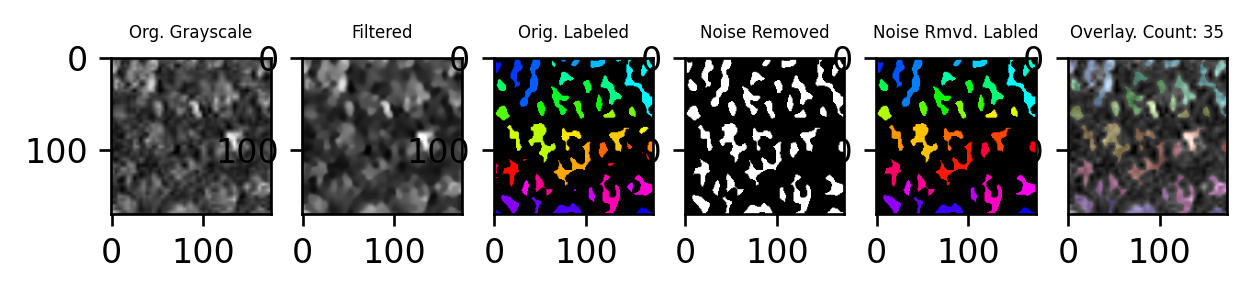

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[45, 3]
2
Countors detected: 27


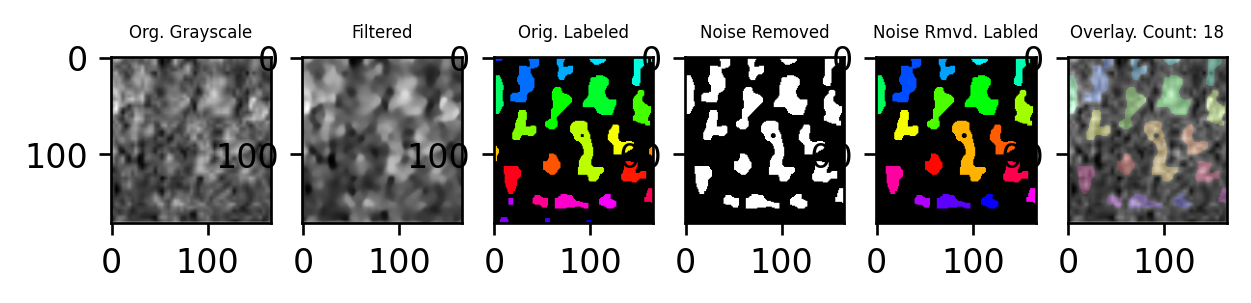

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 62


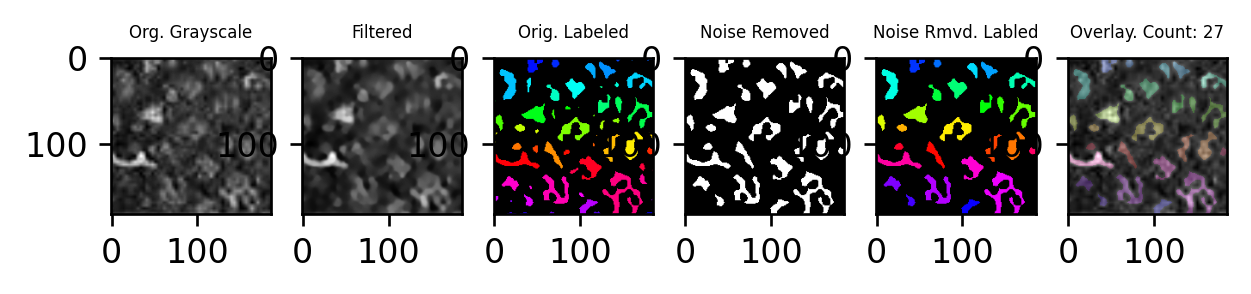

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 49


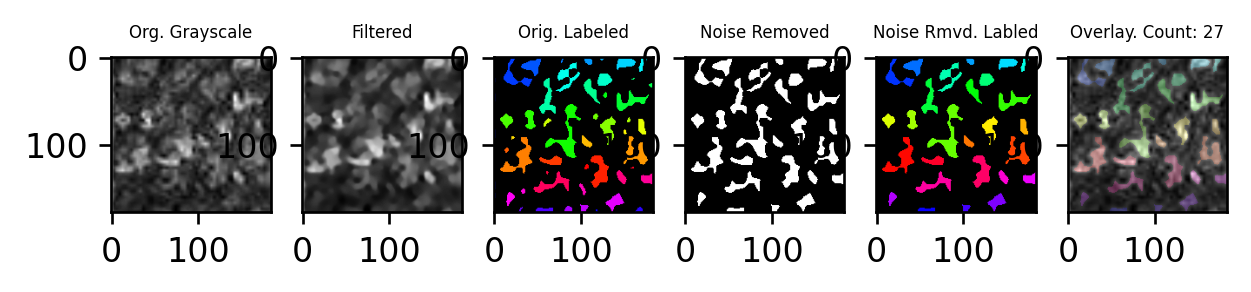

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 51


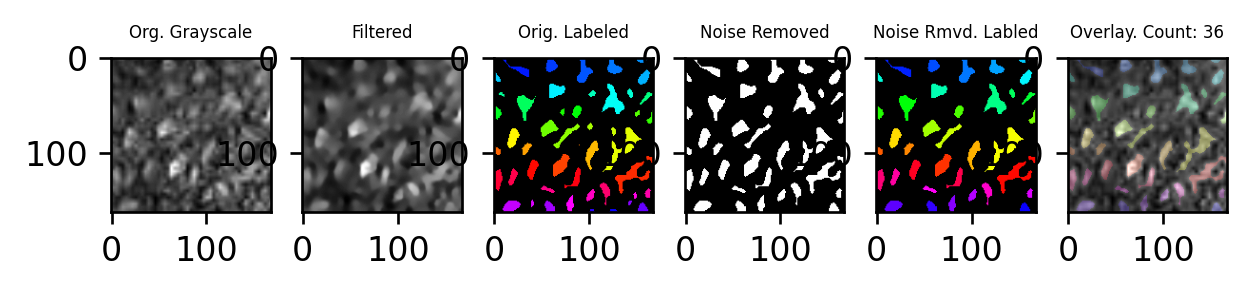

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 52


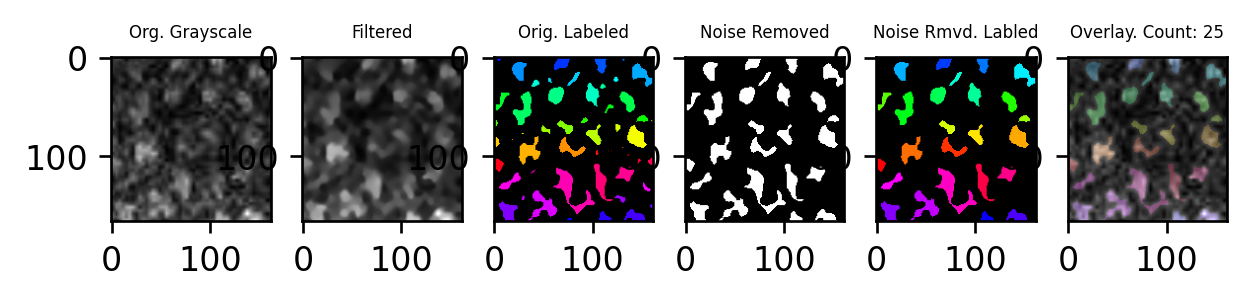

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 16


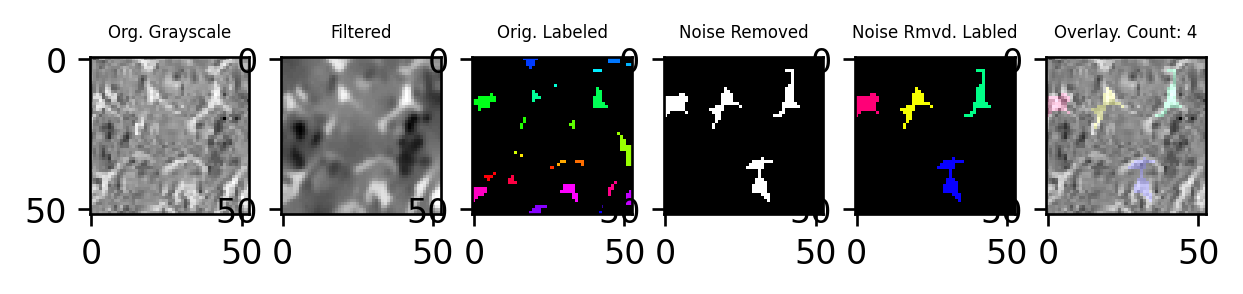

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 73


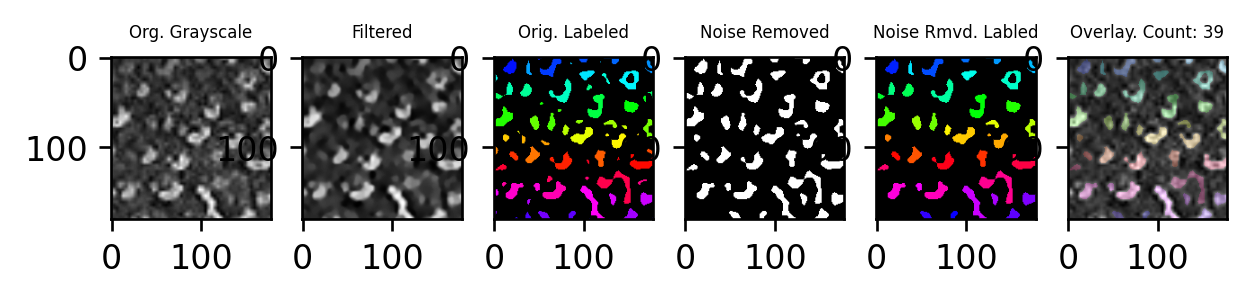

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 15


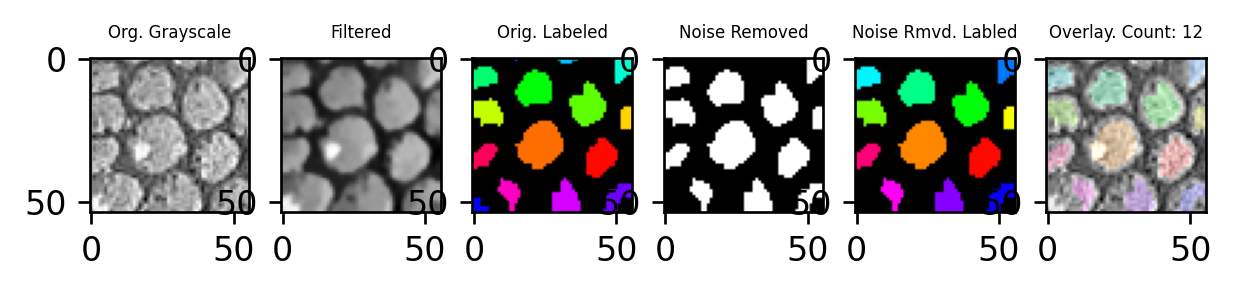

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 59


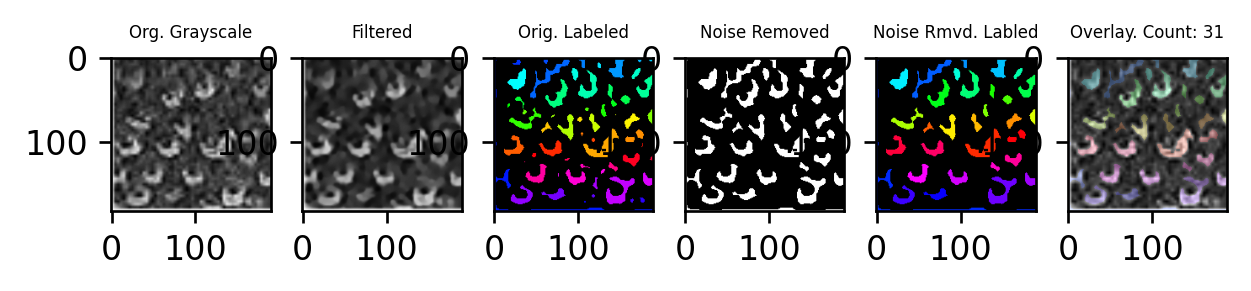

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 47


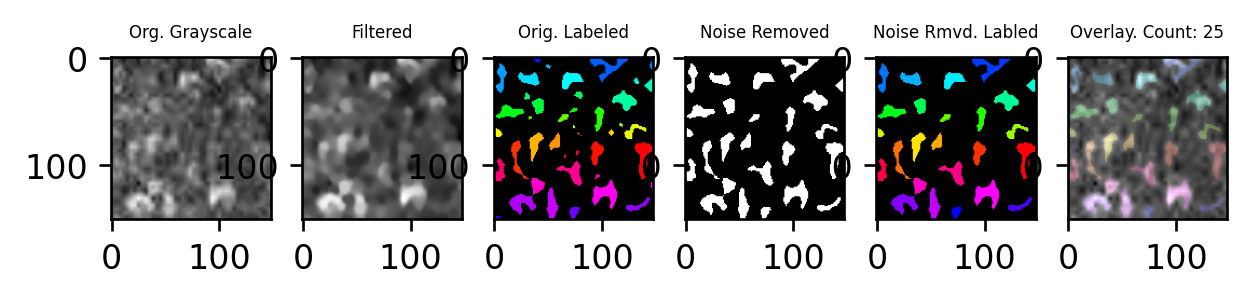

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 16


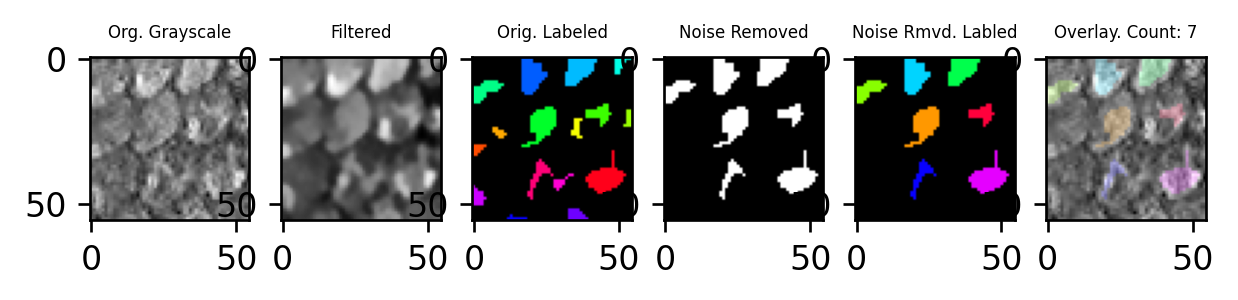

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 11


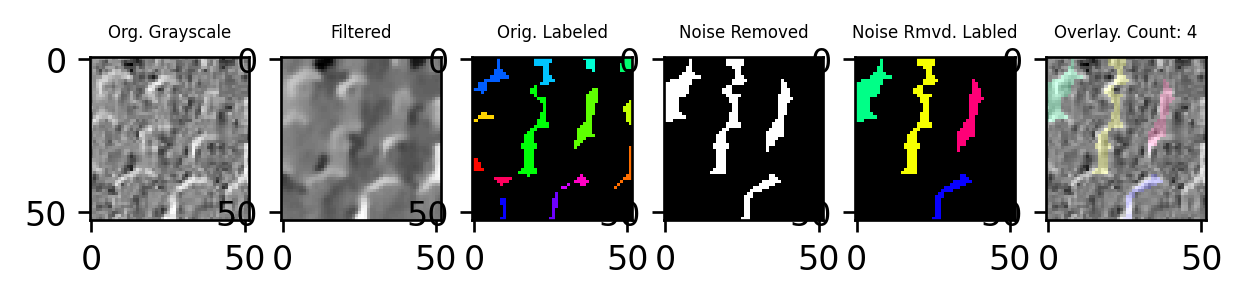

[25, 1]
2
Countors detected: 17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


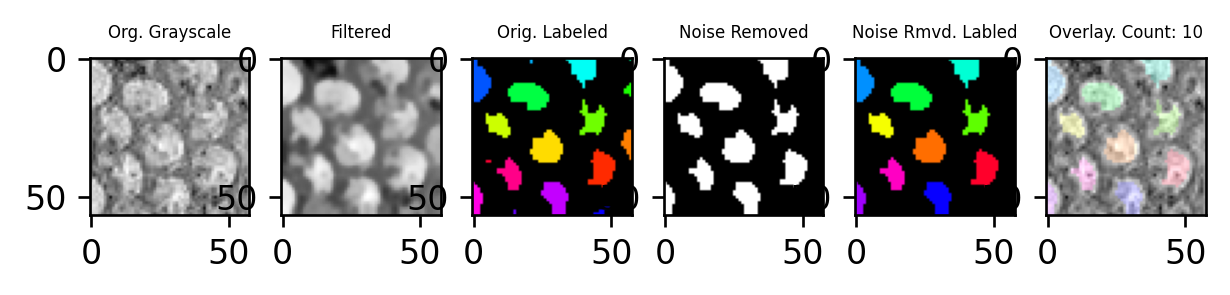

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 37


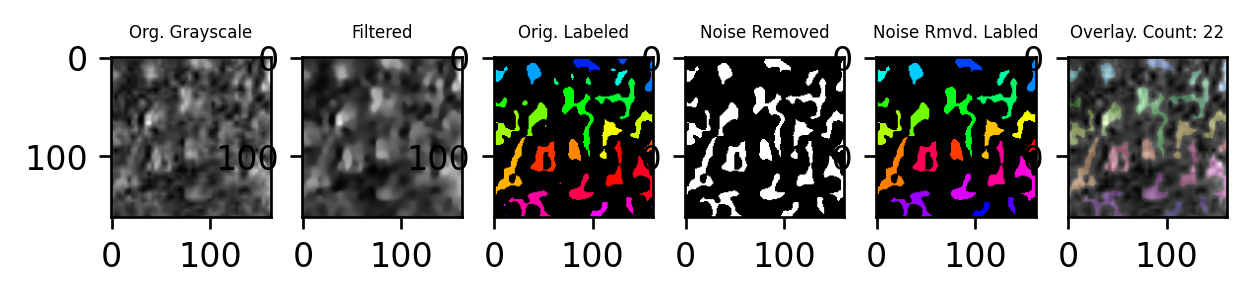

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[45, 3]
2
Countors detected: 21


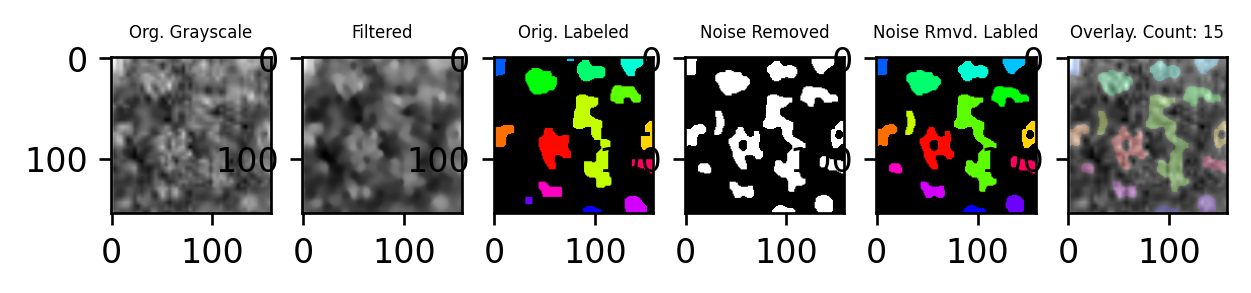

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 69


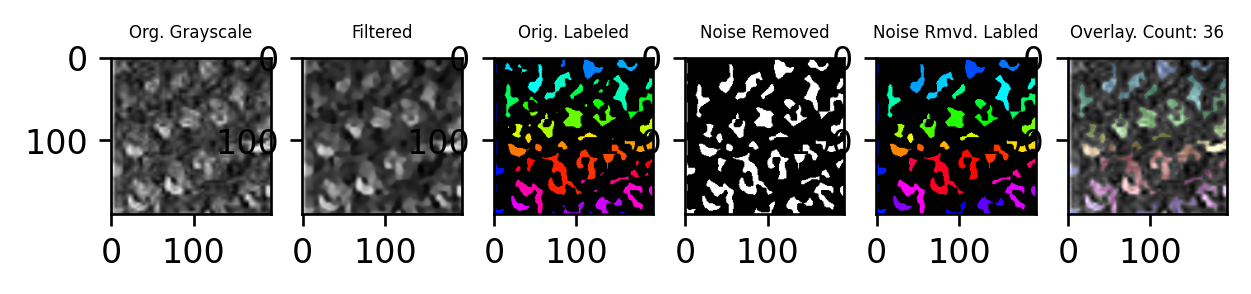

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 12


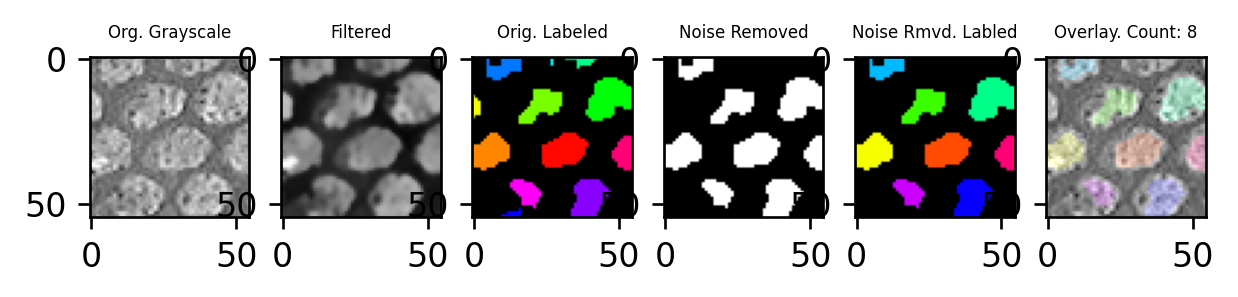

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 22


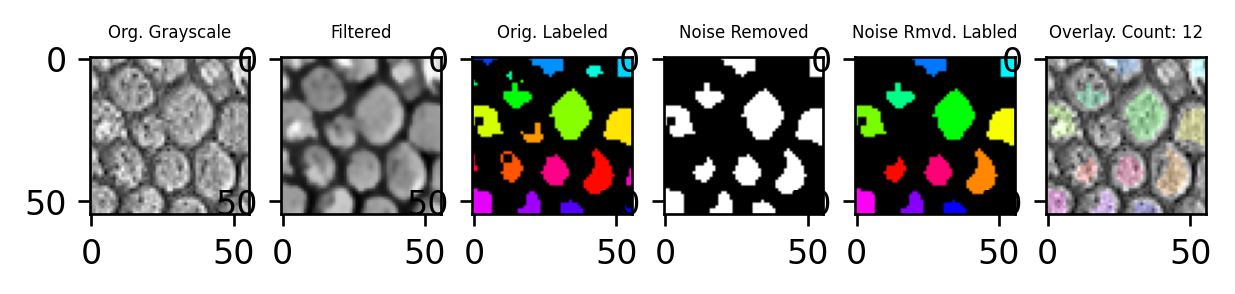

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 45


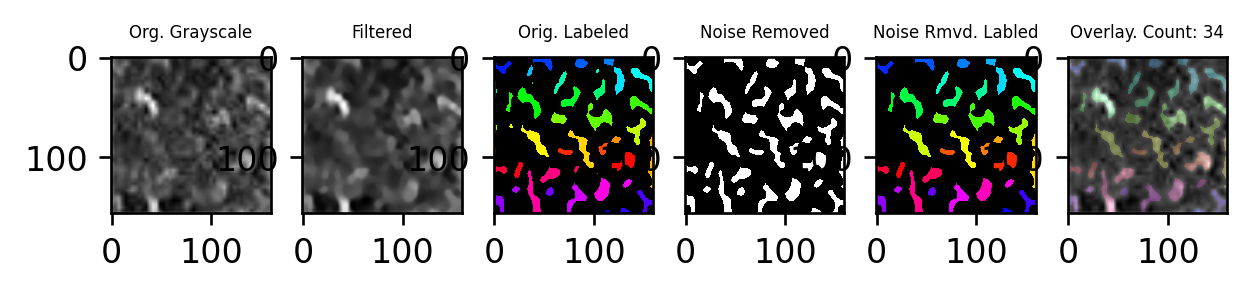

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 16


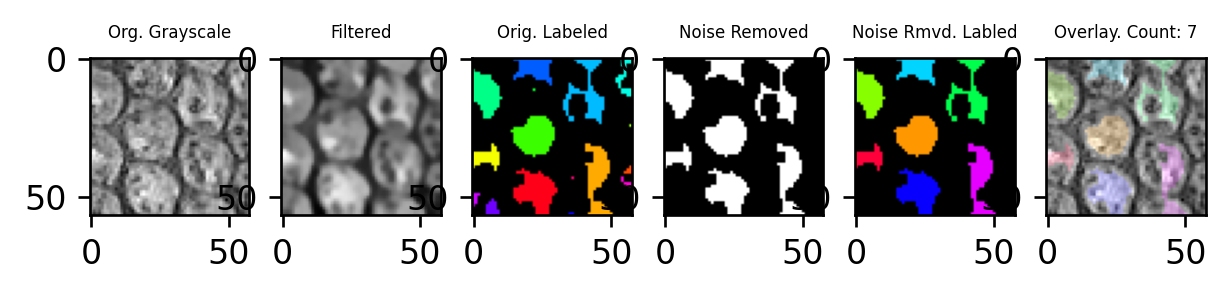

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 14


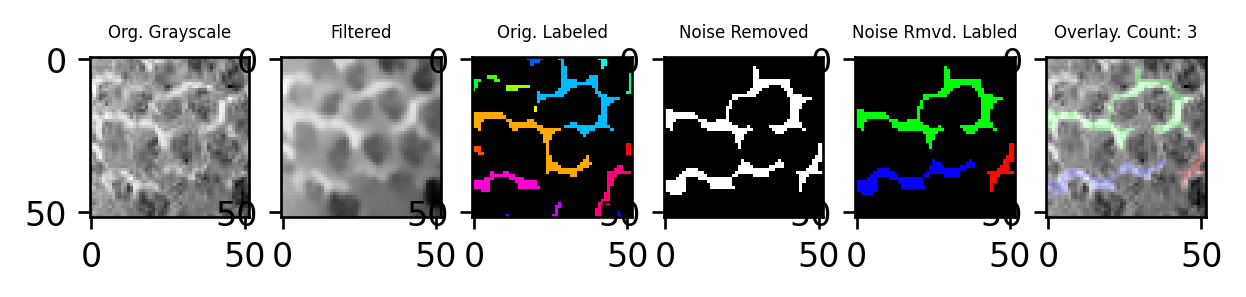

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[65, 4]
2
Countors detected: 13


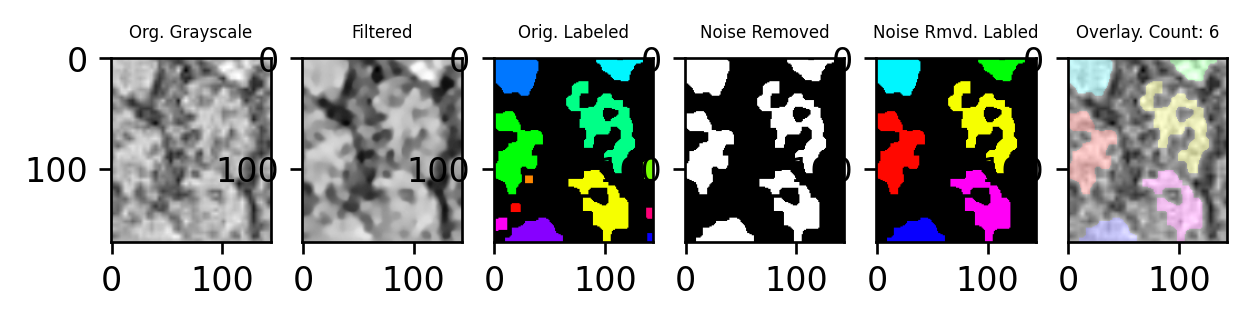

[25, 1]
2
Countors detected: 39


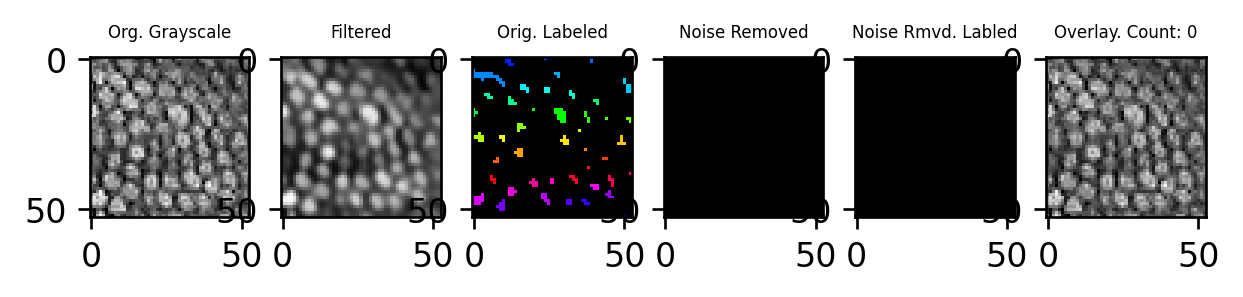

[25, 1]
2
Countors detected: 45


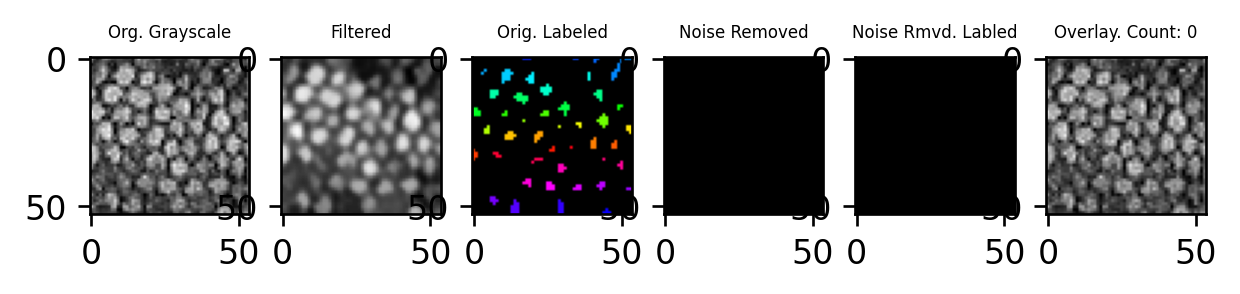

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[65, 4]
2
Countors detected: 20


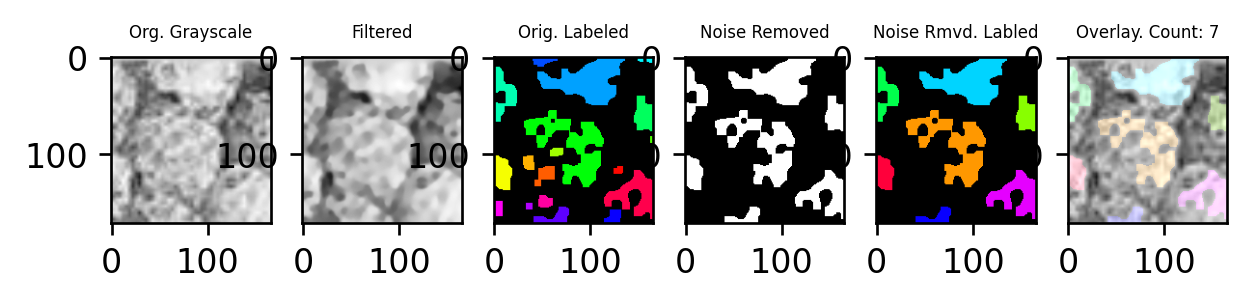

[25, 1]
2
Countors detected: 48


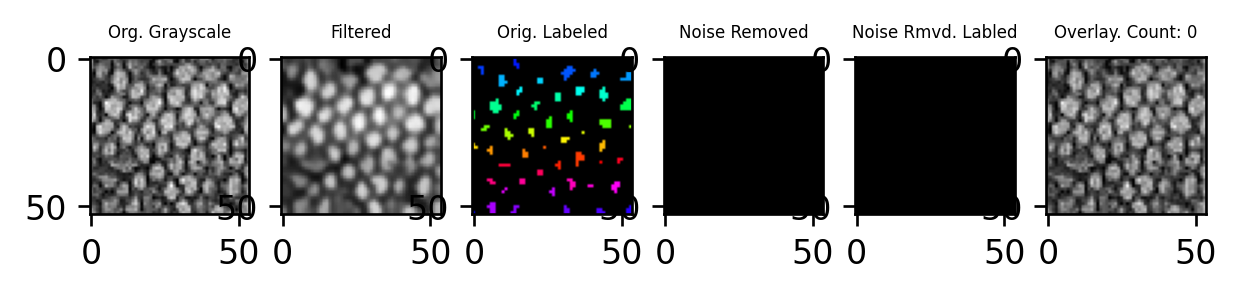

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[65, 4]
2
Countors detected: 11


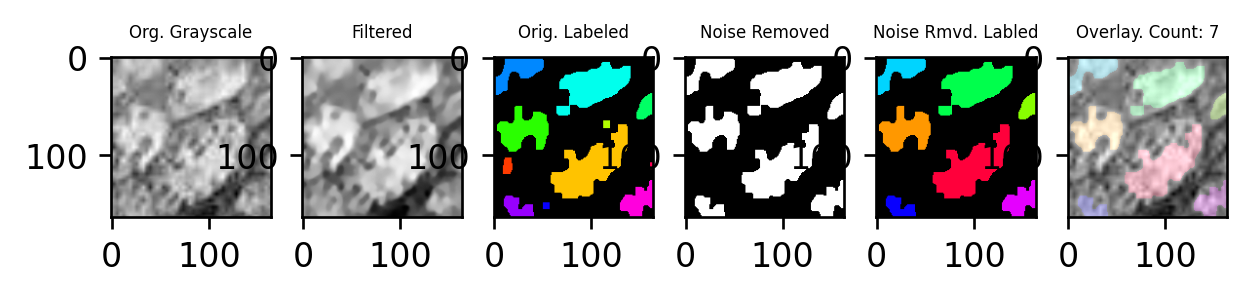

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[65, 4]
2
Countors detected: 9


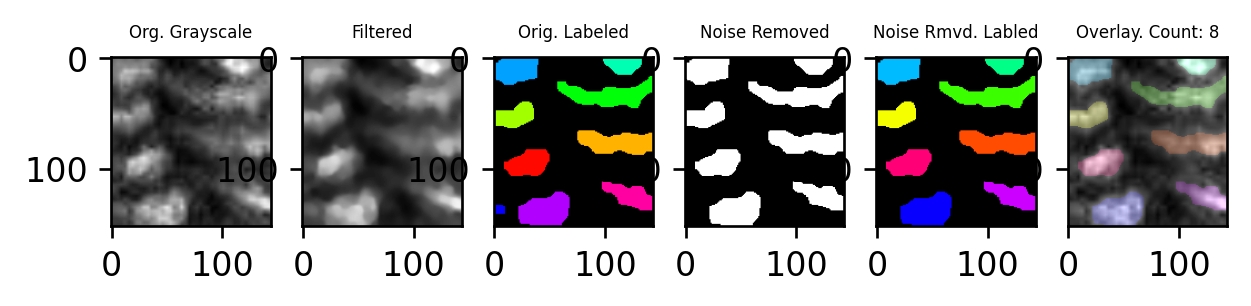

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 14


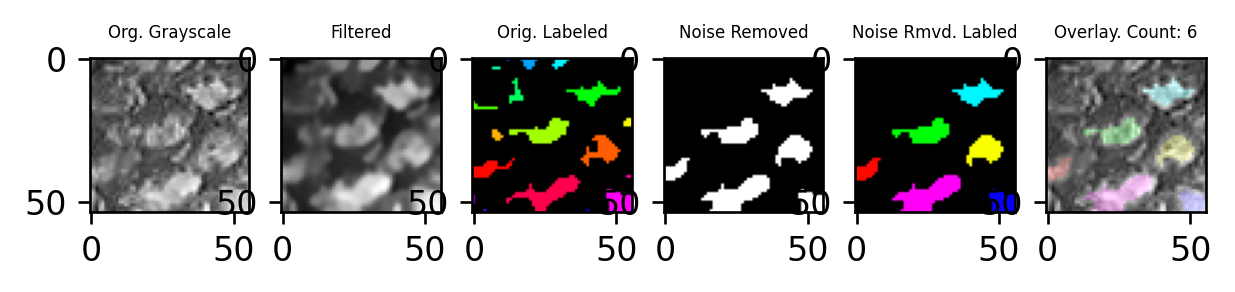

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 10


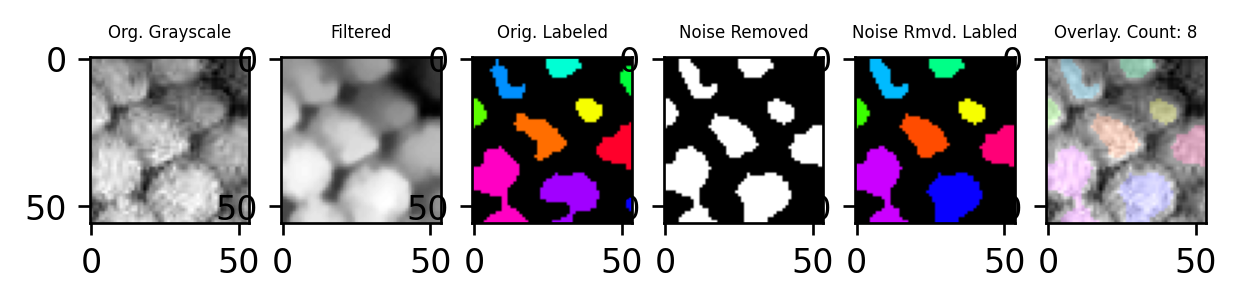

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[65, 4]
2
Countors detected: 9


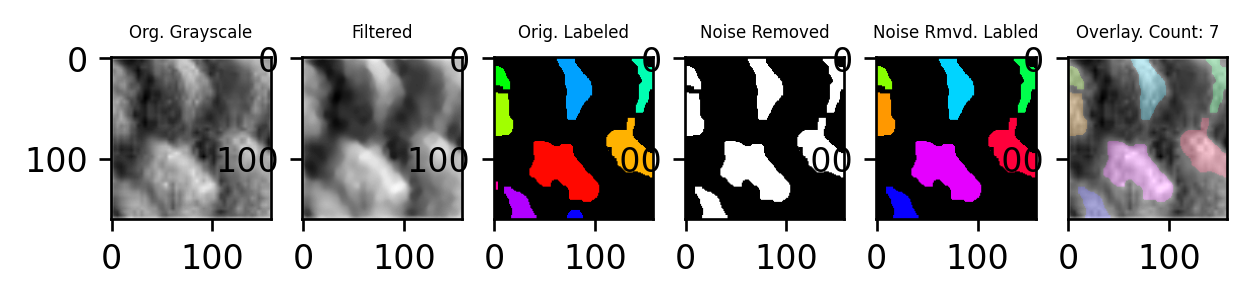

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 15


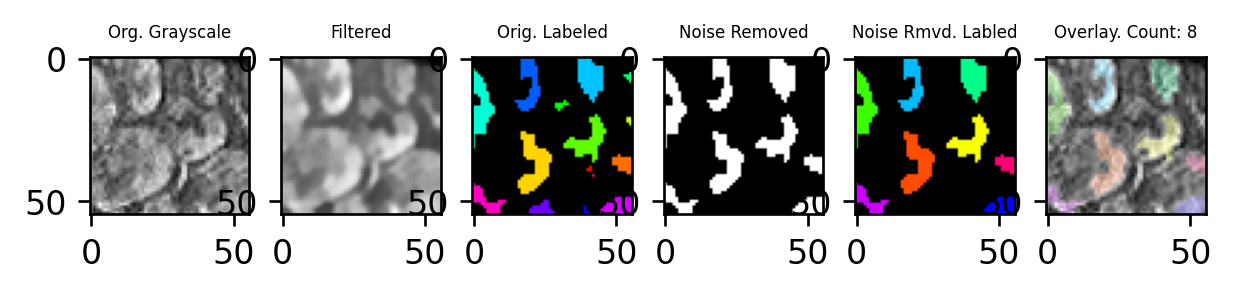

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[45, 3]
2
Countors detected: 9


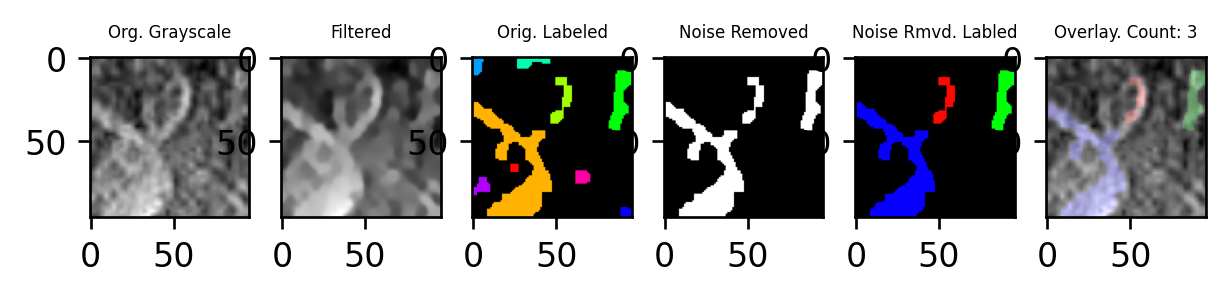

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[15, 1]
2
Countors detected: 53


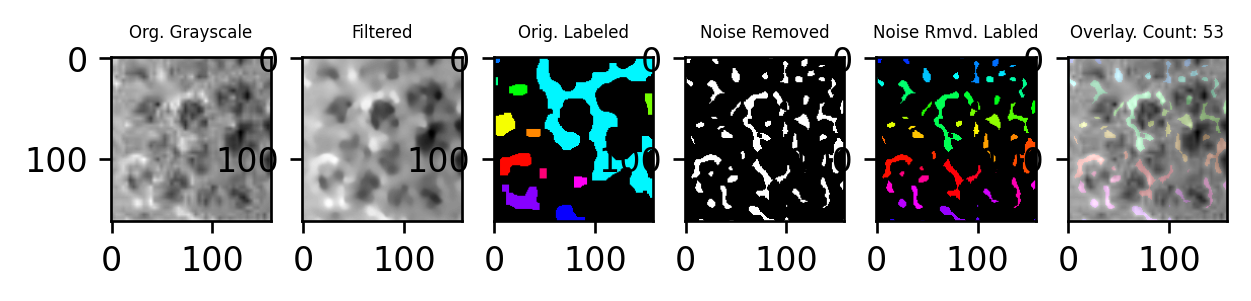

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25, 1]
2
Countors detected: 38


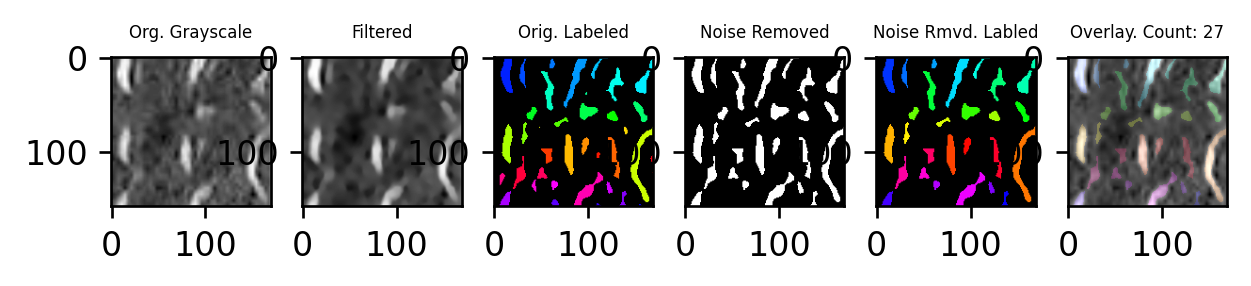

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[65, 4]
2
Countors detected: 15


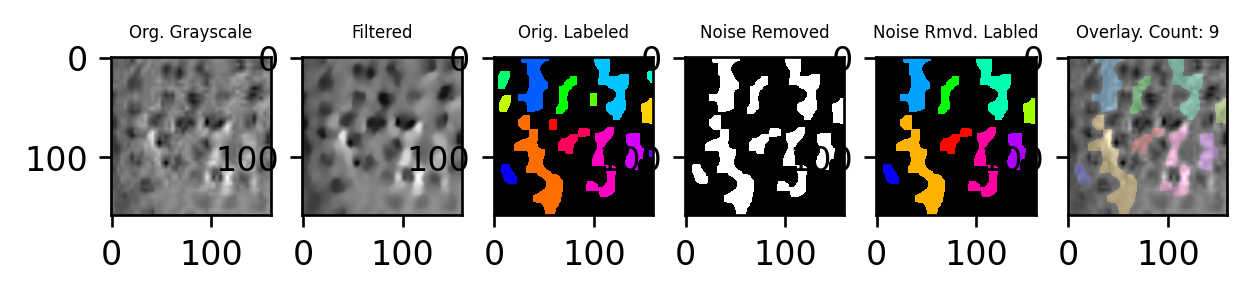

In [52]:
without_r = []
#find a way to draw the contors to see what is detected
#use a different thing????

print("TRYING TO CLEAN UP THE IMAGES AND REMOVE SMALL SPECKELS: SHOULD TAKE INTO ACCOUNT DISTANCE AND SIZE")

index = 0;
final_counts = []

print("Images", len(images))
for img in images:
    print(block_size[index])
    binary_map = (img > 0).astype(np.uint8)
    connectivity = 4 # or whatever you prefer
    output = cv2.connectedComponentsWithStats(binary_map, connectivity, cv2.CV_32S)
    stats = output[2]
    kernel = np.ones((3,3),np.uint8)
    #cnts = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    print(len(cnts))
    
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    print("Countors detected:", len(cnts))
    
    #img = cv2.drawContours(img, cnts, -1, (110,127,0), 1)
    
    if(block_size[index][0] > 15):
        for c in cnts:
            area = cv2.contourArea(c)
            sizes = all_sizes[index]
            #median = sizes.item(int(len(sizes)/2))
            if area < (averages[index]/8) or area < 20:
                img = cv2.drawContours(img, [c], -1, (0,255,0), -1)
    
    plt.subplot(1,6,1), plt.imshow(original_img[index], 'gray')
    plt.title("Org. Grayscale", fontsize=5)
    plt.subplot(1,6,2), plt.imshow(filter_img[index], 'gray')
    plt.title("Filtered", fontsize=5)
    plt.subplot(1,6,3), plt.imshow(labeled_imgs[index], 'gray')
    plt.title("Orig. Labeled", fontsize=5)
    plt.subplot(1,6,4), plt.imshow(img, 'gray')
    plt.title("Noise Removed", fontsize=5)

    count, labels = cv2.connectedComponents(img)                
    count = count - 1 # background doesn't count as a scale
    label_hue = np.uint8(179 * labels / np.max(labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0
    without_r.append(labeled_img)

    plt.subplot(1, 6, 5), plt.imshow(labeled_img, 'gray')
    plt.title("Noise Rmvd. Labled", fontsize=5)
    plt.subplot(1, 6, 6), plt.imshow(overlay(original_img[index], labeled_img))

    final_counts.append(count)
    plt.title("Overlay. Count: " + str(count), fontsize=5)

    plt.show()
    index = index + 1

In [34]:
def trial(names):
    trials = []
    for name in names:
        trials.append("Trial " + str(name[-5]))
    return trials

In [41]:
def shorten(image_names):
    short_image_names = []
    for name in image_names:
        short_image_names.append(str(name[0:-6]))
    return short_image_names

In [42]:
short_image_names = shorten(image_names)
trial_num = Table().with_column("Img Name", short_image_names).group("Img Name").sort("Img Name").column("count")
data = Table().with_columns("Img Name", short_image_names, "trial", trial(image_names), "Counts", final_counts)
data = data.sort("Img Name")
data = data.pivot("trial", "Img Name", "Counts", sum).with_column("# Trials", trial_num)
data = data.with_column("Average", (data.column("Trial 1") + data.column("Trial 2") + data.column("Trial 3") + data.column("Trial 4"))/(data.column("# Trials")))

data.show()

In [43]:
actual = [10, 60, 13, 55, 14, 48, 14, 41, 14, 18, 15, 6, 21, 19, 7, 21, 5, 5]

In [45]:
data = data.with_columns("Hand Counted Average", actual, "% Dif", abs(data.column("Average")/actual))

data.show()